In [1]:
# Imports
import os
import sys
import cmath
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import ltspice
import sympy as sp
from sympy.utilities.lambdify import lambdify
from scipy import signal
#%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from matplotlib.ticker import LogLocator

In [2]:
k = 1.38e-23
T = 300
q = 1.602e-19
V_T = k*T/q

# Photodiode
Cd = 150*1e-12
Id = 2*1e-6

In [3]:
def f1(Rf,GBW,C_TIA,Cd,Id):
    x = sp.symbols('x')
    d = {}
    wt = 2*np.pi*GBW
    Cin = C_TIA+Cd
    Cf = np.sqrt(2*Cin/(Rf*wt))
    f_RC = 1/(Rf*Cin)
    f3db = np.sqrt(GBW/(2*np.pi*Rf*Cin))
    i_ns = np.sqrt(2*q*Id)
    thermal_input = np.sqrt(4*k*T/Rf)
    i_input_ref = np.sqrt(0.122)*i_ns/Rf
    e_input_ref = np.sqrt( (i_input_ref**2)*(Rf)**2)
    d['Rf'] = Rf
    d['Cf'] = Cf
    d['f_RC'] = f_RC
    d['f3db']= f3db
    d['i_ns'] = i_ns
    d['thermal_input'] = thermal_input
    d['i_input_ref'] = i_input_ref
    d['e_input_ref'] = e_input_ref
    return d

In [50]:
Rf = 100*1e3
GBW = 1600*1e6
C_TIA = 5.2*1e-12

f1(Rf,GBW,C_TIA,Cd,Id)

{'Rf': 100000.0,
 'Cf': 5.556622981616415e-13,
 'f_RC': 64432.989690721646,
 'f3db': 4050645.1451525567,
 'i_ns': 8.004998438475799e-13,
 'thermal_input': 4.069397989875161e-13,
 'i_input_ref': 2.796025750954379e-18,
 'e_input_ref': 2.796025750954379e-13}

## Design Project: Low-Noise Wideband Transimpedance Amplifier Design
#### Kevin Egedy
#### June 2, 2021

show picture of architecture

## Spec

| Parameter                                             | Specification |
|:------------------------------------------------------|:--------------|
| Transimpedance gain (full signal path)                | $1$ $V/\mu A$ |
| Transimpedance bandwidth ($f_{3dB}$)                  | $1$ $MHz$     |
| Minimum photodiode current ($i_d$)                    | $2$ $\mu A$   |
| Photodiode capacitance ($C_d$)                        | $150$ $pF$    |
| Closed-loop gain magnitude peaking                    | $0$  $dB$     |
| $rms$ noise figure ($F = 1 + i_n^2/i_{ns}^2$)         | $\leq 0.5$ $dB$ |
| Power dissipation ($I_{DD} \cdot (V_{CC} + V_{EE}) $) | Optimize $mW$ |
| Cost-per-unit (1000 units)                            | Optimize $\$$ |

## Getting Started

[TI-design-transimpedance-amplifier-circuits](https://training.ti.com/how-design-transimpedance-amplifier-circuits)
- [Explore TI Transconductance Amplifiers](http://www.ti.com/lsds/ti/amplifiers/special-function-amplifiers/transconductance-amplifiers-products.page)
- [Transimpedance Considerations for High-Speed Amplifiers](http://www.ti.com/litv/pdf/sboa122)

<div font-size="8px">
<center><img src='img/noise-analysis-circuit.png'></center> 


$\begin{eqnarray}
&& i_{n,in} &=& \sqrt{{i_n}^2 + \frac{4kT}{R_f} + \left(\frac{e_n}{R_f}\right)^2 + \frac{(e_n \cdot 2\pi f_{enb} C_{in})^2}{3}} \\[0.75em]
&& R_f &=& \sqrt{\frac{e_{n_{(FET)}}^2 - e_{n_{(BJT)}}^2}{{i_n}^2_{(BJT)}- {i_n}^2_{(FET)} + \frac{2\pi f_{enb}}{3} (C_{in_{(BJT)}} e_{n_{(BJT)}}^2 - C_{in_{(FET)}} e_{n_{(FET)}}^2) }}
\end{eqnarray}$
</div>


## Compare OPA657 and OPA846

| Name | GBW | $e_n$ | $i_n$ | $C_{in}$  |
|:-----|:---:|:---:|:---:|:----:|
|[OPA657](http://focus.ti.com/docs/prod/folders/print/opa657.html) (FET)| 1600 MHz | 4.8 nV/$\sqrt{\text{Hz}}$| 1.3 fA/$\sqrt{\text{Hz}}$|150pF + 5.2pF = 155.2pF|
|[OPA846](http://focus.ti.com/docs/prod/folders/print/opa846.html) (BJT)| 1750 MHz | 1.2 nV/$\sqrt{\text{Hz}}$| 2.8 pA/$\sqrt{\text{Hz}}$|150pF + 3.8pF = 153.8pF|

## TI: Continued
<div line-height="50%">
<center><img src='img/Bandwidth-vs-Gain.png'></center> 


"Using Equation 13 and comparing two amplifiers with very similar GBP—the OPA846 and the
OPA657—we can then **determine an appropriate transimpedance gain threshold**. Below this threshold, it
is preferable to use bipolar technology to achieve lower noise, while above the threshold it is better to use
FET technology ...

the total input-referred noise
generated by the OPA657 FET amplifier will be lower than that of the OPA846 bipolar amplifier for any
transimpedance gain greater than **2kΩ**.

FET-input operational amplifiers, such as the OPA657, are capable of higher transimpedance, where
decompensated bipolar operational amplifiers are capable of much higher bandwidth but are limited in
gain range."
</div>

## TI Continued: DC-Parameters Consideration

<center><img src='img/310kOhm_example.png'></center>


"The input bias current of the OPA846, 19μA, generates an output offset voltage with the feedback resistor
of 310kΩ of **5.89V**. Because the OPA846 is operating on a ±5V power supply, this offset voltage sends
the output into **saturation**. Adding a 310kΩ resistor on the noninverting input allows bias current
cancellation but now puts 5.89V common-mode voltage on the input, exceeding the common-mode input
range of the OPA846."

## TIA Gain

| Paramete   | Specification |
|:-----------|:--------------|
| Transimpedance gain (full signal path) | $1$ $V/\mu A$ |

<hr>

Based on TI figure, choose TIA gain to be 100K $\Omega$. Will need additional 10 V/V gain stage.

$\begin{eqnarray}
&& \frac{v_o}{i_d} &=& R_f\dfrac{\omega_0^2}{s^2 + 2\zeta\omega_0 + \omega_0^2} \\[0.5em]
&& A_{v,CL} &=& R_f = 100K  \\[0.5em]
\end{eqnarray}$



Desired gain is over 2$K\Omega$ threshold, use FET: [OPA657](http://focus.ti.com/docs/prod/folders/print/opa657.html).

## Filter design (OPA846)


| Paramete   | Specification |
|:-----------|:--------------|
| Closed-loop gain magnitude peaking  | $0$  $dB$     |
| Transimpedance bandwidth ($f_{3dB}$) | $1$ $MHz$     |


<hr>

Butterworth design for 0 dB peaking such that $2\zeta = \dfrac{1}{Q} = 1/\sqrt{2}$. 

Find resulting $C_f$ and $f_{3dB}$. 

$\begin{eqnarray}
&& \omega_t &=& 2 \pi \text{ (1750 MHz)}  \\[0.5em]
&& C_{in} &=& (150 \text { pF}) + (\sim 5 \text { pF}) = 155 \text { pF} \\[0.5em]
&& C_f &=& \sqrt{\dfrac{2\cdot C_{in}}{R_f\omega_t}} = 0.53 \text { pF} \\[0.5em]
&& \omega_{3dB} = \omega_0 &=& \sqrt{\dfrac{\omega_t}{R_f(C_{in} + C_f)}} \\[0.5em]
&& f_{3dB} &=& \omega_{3dB}/(2\pi) = 4.2 \text{ MHz} \\[0.5em]
\end{eqnarray}$

## Noise Threshold

| Parameter  | Specification |
|:-----------|:--------------|
| $rms$ noise figure | $\leq 0.5$ $dB$ |

<hr>

Setup noise calculations.

$\begin{eqnarray}
&& F &=& 1 + i_{n,out}^2/i_{ns}^2 \\[0.5em]
&& \dfrac{e_{na,out}}{e_{na}} &=& \left(1+\dfrac{Z_f}{Z_{in}}\right) = \dfrac{1+s(C_{in}+C_f)R_f}{1+sC_fR_f} \\[0.5em]
\end{eqnarray}$

<hr>

$\begin{eqnarray}
&& 0.5 &=& 10\log_{10}{\left(1 + i_{n,out}^2/i_{ns}^2\right)} \\[0.5em]
&& 1.122 &=& 1 + i_{n,out}^2/i_{ns}^2 \\[0.5em]
&& 0.122 &=& i_{n,out}^2/i_{ns}^2 \\[0.5em]
&& i_{n,out} &=& \sqrt{0.122 \cdot i_{ns}^2}\\[0.5em]
&& i_{n,out} &=& 0.35 \cdot i_{ns} \\[0.5em]
&& i_{n,out} &=& 0.28 pA /\sqrt{\text{Hz}} \\[0.5em]
\end{eqnarray}$

## Noise Design (OPA657)

| Parameter                 | Specification |
|:--------------------------|:--------------|
| Minimum photodiode current ($i_d$) | $2$ $\mu A$ |

<hr>

Input Photodiode Current Noise Density

$\begin{eqnarray}
&& i_{ns}^2 &=& 2qi_d \\[0.5em]
&& i_{ns} &=& \sqrt{2qi_d} = 0.8 \text{ pA}/ \sqrt{Hz} \\[0.5em]
\end{eqnarray}$

<hr>

Input-Referred Thermal Noise Density

$\begin{eqnarray}
&&  i_{n,R_f} &=& \frac{\sqrt{4kT R_f}}{R_f} = \sqrt{\frac{4kT}{R_f}} = 0.41 \text{ pA}/\sqrt{\text{Hz}} \\[0.5em]
\end{eqnarray}$

<hr>

Input-Referred Op Amp Noise

$\begin{eqnarray}
&&  i_{n,R_f} &=& \frac{e_n}{R_f} = \frac{4.8 nV}{100K} = 48 \text{ fA}/\sqrt{\text{Hz}} \\[0.5em]
\end{eqnarray}$

In [29]:
np.sqrt((1.3*1e-15)**2 + (4*k*T)/(100*1e3) + ((4.8*1e-9)/(100*1e3))**2)

4.0976296806812596e-13

## Noise Density (OPA657)

| Parameter  | Specification |
|:-----------|:--------------|
| $rms$ noise figure | $\leq 0.5$ $dB$ |
| $i_{n,out}$ | 0.28 pA /$\sqrt{\text{Hz}}$ |

<hr>

Input-Referred Current Noise Density 
- Exclude shot noise
- Exclude TIA Transfer Function

$\begin{eqnarray}
&& i_{n,in} &=& \sqrt{{i_{na}}^2 + \frac{4kT}{R_f} + \left(\frac{e_n}{R_f}\right)^2} \\[0.5em]
&& i_{n,in} &=& \sqrt{{(1.3 fA)}^2 + \frac{4kT}{100K} + \left(\frac{4.8 nV}{100K}\right)^2} \\[0.5em]
&&  i_{n,in} &=&  0.41 \text{ pA}/\sqrt{\text{Hz}} \\[0.5em]
\end{eqnarray}$


## Searching for the best TIA

| Name | $E_n$ | $I_n$ | $C_s$  |
|:-----|:---|:---|:----|
|  | |||

## Gain Stages

| Parameter   | Specification |
|:-----------|:--------------|
| Transimpedance gain (full signal path) | $1$ $V/\mu A$ |

<hr>

TIA: 

In [66]:
# Plot Input-Referred Current Noise Density
s,e_na,i_na,C_TIA = sp.symbols('s,e_na,i_na,C_TIA')
f = np.logspace(0, 7, 10000)
w = 2*np.pi*f

# OPA657
components1 = {
    e_na : 4.8*1e-9,
    i_na : 1.3*1e-15,
    C_TIA : 5.2*1e-12
}
# OPA846
components2 = {
    e_na : 1.2*1e-9,
    i_na : 2.8*1e-12,
    C_TIA : 3.8*1e-12
}

i_ns = 2*q*Id
GBW = 1600*1e6
wt = 2*sp.pi*GBW
Rf = 100*1e3
Cin = Cd + C_TIA
Cf = sp.sqrt(2*Cin/(2*sp.pi*GBW*Rf))
en = e_na*((Cin+Cf)*Rf*s + 1)/(Cf*Rf*s + 1)
noise_sq = i_na**2 + 4*k*T/Rf + (en/Rf)**2 # + (1/3)*(en*2*sp.pi*fenb*Cin)**2
noise = sp.sqrt(noise_sq)

In [67]:
H = sp.Matrix([noise])
H1 = H.subs(components1)
H2 = H.subs(components2)
H1 = lambdify(s,H1,modules='numpy')
H1 = H1(1j*w)
H1 = H1[0][0]
H2 = lambdify(s,H2,modules='numpy')
H2 = H2(1j*w)
H2 = H2[0][0]

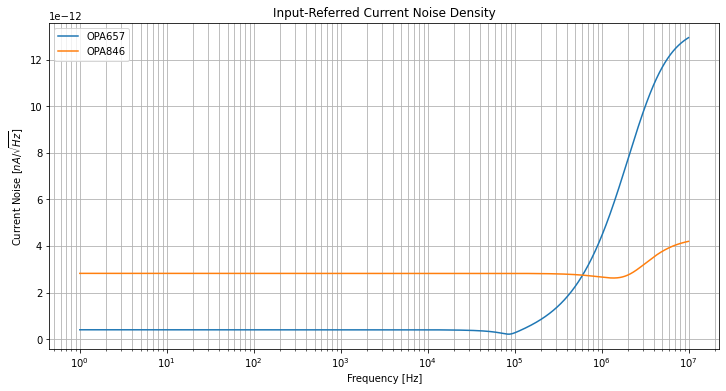

In [68]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set_title('Input-Referred Current Noise Density')
ax.semilogx(f, abs(H1),label=r'OPA657')
ax.semilogx(f, abs(H2),label=r'OPA846')
ax.set_ylabel(r'Current Noise [$nA/\sqrt{Hz}$]')
ax.set_xlabel('Frequency [Hz]')
ax.ticklabel_format(style='sci',axis='y',scilimits=(-12,-12))
ax.grid(which='both', axis='both')
ax.legend()
plt.show();

In [69]:
f = np.logspace(0, 5, 10000)
w = 2*np.pi*f

H = sp.Matrix([10*sp.log(1+noise_sq/i_ns,10)])
H1 = H.subs(components1)
H2 = H.subs(components2)
H1 = lambdify(s,H1,modules='numpy')
H1 = H1(1j*w)
H1 = H1[0][0]
H2 = lambdify(s,H2,modules='numpy')
H2 = H2(1j*w)
H2 = H2[0][0]

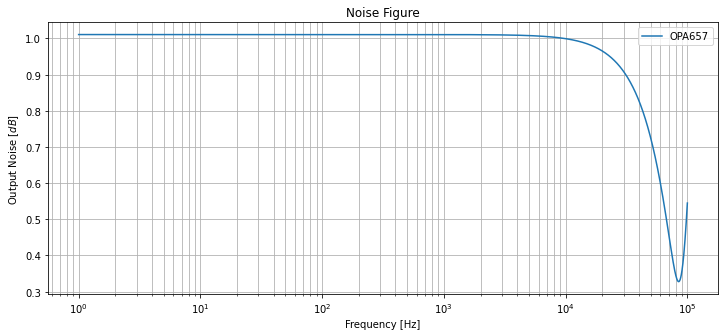

In [74]:
fig, ax = plt.subplots(figsize=(12,5))
ax.set_title('Noise Figure')
ax.semilogx(f, abs(H1),label=r'OPA657')
#ax.semilogx(f, abs(H2),label=r'OPA846')
ax.set_ylabel(r'Output Noise [$dB$]')
ax.set_xlabel('Frequency [Hz]')
ax.grid(which='both', axis='both')
ax.legend()
plt.show();

In [47]:
f3db = sp.sqrt(GBW/(2*sp.pi*Rf*Cin))
# fenb = 1.11*f3dB
w0 = sp.sqrt(wt/(Cin+Cf)/Rf)
zeta = Rf*Cf*w0/2
TIA = (Rf*w0**2)/(s**2 + 2*s*zeta*w0 + w0**2)

In [48]:
H = sp.Matrix([TIA])
H1 = H.subs(components1)
H2 = H.subs(components2)
H1 = lambdify(s,H1,modules='numpy')
H1 = H1(1j*w)
H1 = H1[0][0]
H2 = lambdify(s,H2,modules='numpy')
H2 = H2(1j*w)
H2 = H2[0][0]

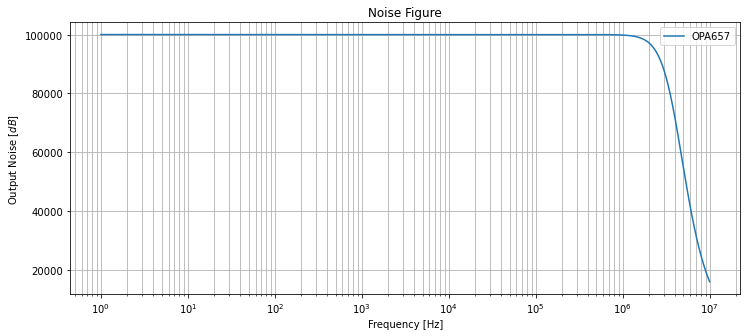

In [49]:
fig, ax = plt.subplots(figsize=(12,5))
ax.set_title('Noise Figure')
ax.semilogx(f, abs(H1),label=r'OPA657')
#ax.semilogx(f, abs(H2),label=r'OPA846')
ax.set_ylabel(r'Output Noise [$dB$]')
ax.set_xlabel('Frequency [Hz]')
ax.grid(which='both', axis='both')
ax.legend()
plt.show();

## Continued: Find Voltage Noise Threshold

Input-Referred Thermal Noise Density:

$\begin{eqnarray}
&&  i_{n,R_f} &=& \frac{\sqrt{4kT R_f}}{R_f} = \sqrt{\frac{4kT}{R_f}} = 0.41 \text{ pA} \\[0.5em]
\end{eqnarray}$

<hr>

Current Noise Density excluding shot:

$\begin{eqnarray}
&& i_{n,in} &=& \sqrt{{i_n}^2 + \frac{4kT}{R_f} + \left(\frac{e_n}{R_f}\right)^2} \\[0.5em]
&& i_{n,in}^2 &\approx& \sqrt{\frac{4kT}{R_f} + \left(\frac{e_n}{R_f}\right)^2} \\[0.5em]
&& \left(\frac{e_n}{R_f}\right)^2  &=& i_{n,in}^2  - \frac{4kT}{R_f} \\[0.5em]
&& e_{n,in}  &=&  R_f \sqrt{i_{n,in}^2   - \frac{4kT}{R_f}} & \text{ not solvable; thermal noise is larger} \\[0.5em]
\end{eqnarray}$

## Continued: Assume Noiseless Rf

Input-Referred Voltage Noise Density:

$\begin{eqnarray}
&& i_{n,in}^2 &\approx& \left[\text{op amp noise}\right]^2 \\[0.5em]
&& \left(\frac{e_n}{R_f}\right)^2  &=& i_{n,in}^2  \\[0.5em]
&& e_{n,in} &=&  i_{n,in} R_f \\[0.5em]
&& &=& \frac{i_{n,out}}{R_f} R_f \\[0.5em]
&& &=& 0.28 \text{ pV}/ \sqrt{Hz} \\[0.5em]
\end{eqnarray}$

Voltage noise density must be less than $\sqrt{0.122} \cdot i_{ns}$

Choose $R_f$ to be such that $R_f = 100 \Omega$ so that achievable performance can be met.

Need additional stages. Best TIA's have performance on the order of $\sim 1 \text{ nV}/ \sqrt{Hz}$.